In [1]:
import sys 

import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from unet_2d import *
from unet_2d_res import *
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
print(tf.__version__)

1.14.0


Using TensorFlow backend.


In [2]:
sys.path.append("../")
from metrics import *

In [3]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [4]:
image_generator = ImageDataGenerator(
    rotation_range=12,
    rescale=1./255,
    shear_range=.1,
    zoom_range=.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

label_generator = ImageDataGenerator(
    rotation_range=12,
    shear_range=.1,
    zoom_range=.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

In [5]:
train_generator = train_generator(
    TRAIN_PATH,
    image_generator,
    label_generator, 
    batch_sz=12
)
val_generator = val_generator(
    TRAIN_PATH,
    image_generator,
    label_generator, 
    batch_sz=4
)

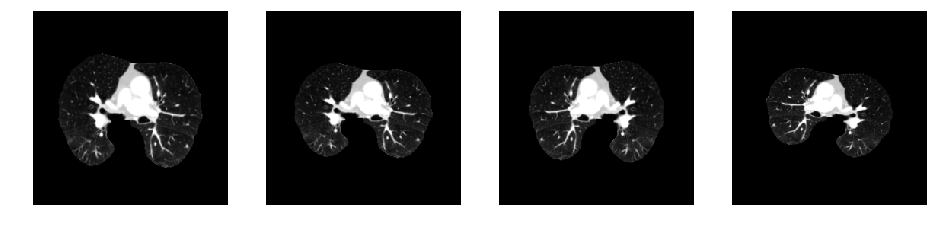

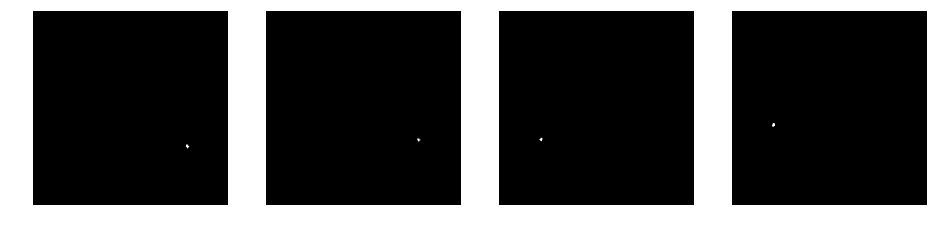

In [6]:
show_augmentation('data/train/image/0.tif', image_generator, n_rows=1)
show_augmentation('data/train/label/0.tif', label_generator, n_rows=1)

## Instantiate the U-Net

In [7]:
model = unet_2d_res()
model.compile(
    optimizer = Adam(lr = 8e-5),
#     loss=hausdorff_loss,
    loss=weighted_cross_entropy,
#     loss=dice_coef_weighted_loss,
    metrics = [
        'accuracy',
#         dice_coef,
#         jaccard_distance,
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.SpecificityAtSensitivity(.5),
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=0, save_best_only=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
targets is deprecated, use labels instead


In [8]:
# model.summary()

## Train the U-Net

In [9]:
model_history = model.fit_generator(
    train_generator,
    validation_data= val_generator,
    validation_steps=100,
    steps_per_epoch = 500,
    epochs = 20,
    callbacks=[model_checkpoint]
)

Found 414 images belonging to 1 classes.
Found 414 images belonging to 1 classes.
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
499/500 [============================>.] - ETA: 0s - loss: 0.0176 - acc: 0.9978 - precision: 0.3969 - recall: 0.3395 - specificity_at_sensitivity: 0.9978Found 46 images belonging to 1 classes.
Found 46 images belonging to 1 classes.
500/500 [==============================] - 170s 339ms/step - loss: 0.0176 - acc: 0.9978 - precision: 0.3967 - recall: 0.3397 - specificity_at_sensitivity: 0.9978 - val_loss: 0.0181 - val_acc: 0.9941 - val_precision: 0.0929 - val_recall: 0.4827 - val_specificity_at_sensitivity: 0.9944
Epoch 2/20
500/500 [==============================] - 153s 306ms/step - loss: 0.0136 - acc: 0.9982 - precision: 0.6498 - recall: 0.4607 - specificity_at_sensitivity: 0.9995 - val_loss: 0.0084 - val_acc: 0.9989 - val_precision: 0.8769 - val_recall: 0.3016 - val_specificity_at_sensitivity: 0.9997

## Save Trained Model 

In [10]:
model.save('unet_lidc.hdf5') 

In [11]:
model.load_weights('unet_lidc.hdf5')

## Test the U-Net

**Training set test**

298


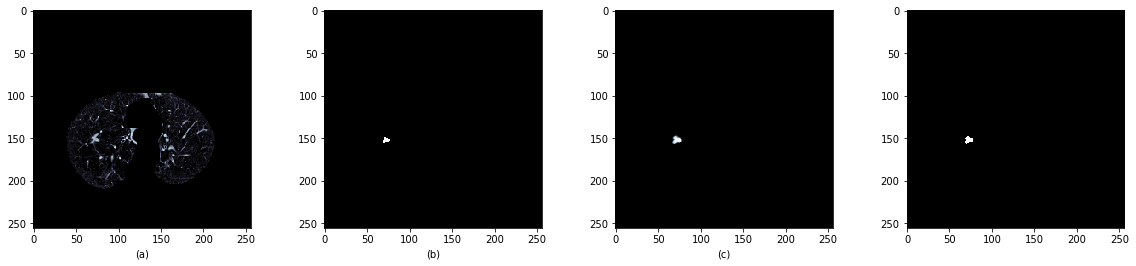

In [15]:
train_idx = np.random.randint(len(os.listdir('data/train/image')))
print(train_idx)
# train_idx = 449
img0 = io.imread(f'data/train/image/{train_idx}.tif', as_gray=True)/255
mask0 = io.imread(f'data/train/label/{train_idx}.tif', as_gray=True)
x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))
# results = model.predict_generator(train_generator, 2, verbose=1)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), cmap='bone')
axs[3].imshow(np.round(result.reshape(256, 256)), cmap='bone')

axs[0].set_xlabel("(a)")
axs[1].set_xlabel("(b)")
axs[2].set_xlabel("(c)")

# for ax in axs:
#     ax.set_xticks([])
#     ax.set_yticks([])


plt.show()

**Test set test**

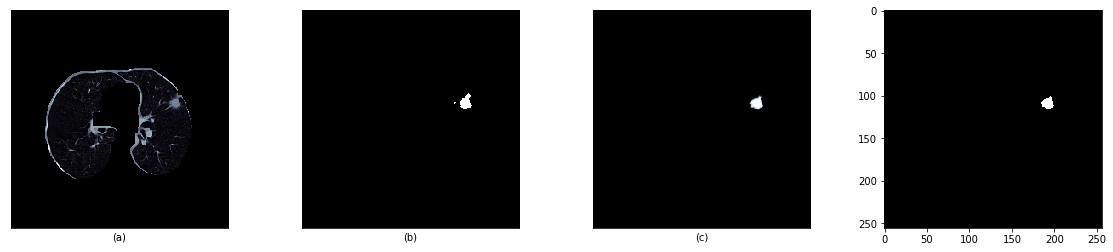

In [21]:
test_idx = np.random.randint(len(os.listdir('data/test/image')))
# test_idx = 53
img0 = io.imread(f'data/test/image/{test_idx}.tif', as_gray=True)/255
mask0 = io.imread(f'data/test/label/{test_idx}.tif', as_gray=True)

x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))
# results = model.predict_generator(train_generator, 2, verbose=1)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), cmap='bone')
axs[3].imshow(np.round(result.reshape(256, 256)), cmap='bone')

axs[0].set_xlabel("(a)")
axs[1].set_xlabel("(b)")
axs[2].set_xlabel("(c)")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.show()